# Pendulum Robust Optimal Control Using `immrax`

In this example, we use Automatic Differentiation to solve a robust optimal control problem in the embedding space of a nonlinear pendulum. In particular, we build an objective function with robust constraints, automatically create and compile functions evaluating their gradients, Jacobians, and Hessians, and finally setup an interior point minimization problem to find a locally optimal solution using IPOPT.

This example is from the paper "$\texttt{immrax}$: A Parallalizable and Differentiable Toolbox for Interval Analysis and Mixed Monotone Reachability in JAX".

## Preliminaries

In [1]:
import jax
import jax.numpy as jnp
import immrax as irx
from typing import Tuple

We will be using IPOPT to solve a minimization problem. Since IPOPT is CPU-based and 64-bit, we configure JAX with these options as well. We can use the GPU here instead of the CPU for some operations, but empirically, the time to transfer data between the CPU and GPU is much larger than the amount of time the problem takes on the CPU only.

In [2]:
# Some configurations
jax.config.update("jax_enable_x64", True)

# We wrap the jax.jit function to set the backend to cpu by default for convenience.
device = 'cpu'
def jit (*args, **kwargs):
    kwargs.setdefault('backend', device)
    return jax.jit(*args, **kwargs)

### The pendulum's dynamics
Consider the dynamics of a forced, damped pendulum
$$
ml^2\ddot{\theta} + b\dot{\theta} + mgl\sin(\theta) = \tau
$$
with with $m=0.15\mathrm{kg}$, $l=0.5\mathrm{m}$, $b=0.1\mathrm{N\cdot m \cdot s}$, and $g=9.81\mathrm{m}/\mathrm{s}^2$.
The torque $\tau := (1 + w)u$, where $u\in\mathbb{R}$ is the desired torque input and $w\in[\underline{w},\overline{w}] := [-0.02,0.02]$ is a bounded multiplicative disturbance on the control input. We implement this as a $2$-state system with $x := (\theta, \dot{\theta})$,
$$
\dot{x} = 
     f(x,u,w) = 
     \left[\begin{matrix} x_2 \\ \frac{(1 + w)u - bx_2}{ml^2} - \frac{g}{l}\sin x_1 \end{matrix}\right]
$$
This is implemented in `immrax` as a `System`, with the specified dynamics written using `jax.numpy`.

In [3]:
g = 9.81

class Pendulum (irx.System) :
    m:float
    l:float
    b:float

    def __init__(self, m:float = 0.15, l:float = 0.5, b:float = 0.1) -> None:
        super().__init__()
        # Tells immrax that the system is continuous
        self.evolution = 'continuous'
        # Tells immrax the number of states
        self.xlen = 2
        self.m = m
        self.l = l
        self.b = b

    def f(self, t: float, x: jax.Array, u: jax.Array, w: jax.Array) -> jax.Array:
        return jnp.array([
            x[1],
            (((1 + w[0])*u[0] - self.b*x[1]) / 
                ((self.m) * self.l**2)) - (g/self.l)*jnp.sin(x[0])
        ])
    
    def get_xy (self, x:jax.Array) :
        return self.l*jnp.sin(x[0]), -self.l*jnp.cos(x[0])

sys = Pendulum()

### Problem Statement
We seek to find a finite-time closed-loop optimal control policy $\pi:[0,T]\times\mathbb{R}^n\to\mathbb{R}$ to swing up the pendulum to an *a priori* safe region at the top.
We consider linear feedback control policies of the form $\pi(t,x) := K(x(t) - x_{\mathrm{nom}}(t)) + u_{\mathrm{ff}}(t)$, where $K$ is a time invariant linear closed-loop stabilizing term to help counter the disturbance, $u_{\mathrm{ff}}:[0,T]\to\mathbb{R}$ is a feedforward control policy, and $x_\mathrm{nom}:[0,T]\to\mathbb{R}^n$ is the nominal trajectory of the deterministic system under the feedforward control law $u_\mathrm{ff}$ with known disturbance mapping $w_{\mathrm{nom}}:[0,T]\to\mathbb{R}$.
The closed-loop system is thus
$$ 
    \dot{x} = f(x,\pi(t,x),w) = f^\pi (t, x, w).
$$

## Embedding System for the Pendulum
Consider the following function
$$ 
\begin{aligned}
    [\textsf{F}^\pi(t,\underline{x},\overline{x},\underline{w},\overline{w})] := &\, ([\textsf{M}_x] + [\textsf{M}_u]K)([\underline{x},\overline{x}] - x_\mathrm{nom}(t)) \\
    % &+ [\textsf{M}_u^\mathcal{O}]([\ulu,\olu] - \mathring{u}) 
    & + [\textsf{M}_w]([\underline{w},\overline{w}] - w_\mathrm{nom}(t)) \\
    & + f(x_\mathrm{nom}(t),u_{\mathrm{ff}}(t),w_\mathrm{nom}(t)),
\end{aligned}
$$
with $[\textsf{M}_x\ \textsf{M}_u\ \textsf{M}_w] := [\textsf{M}_\mathcal{O}^{\xi_\mathrm{nom}(t)}(\underline{x},\overline{x},u_\mathrm{ff}(t),u_\mathrm{ff}(t),\underline{w},\overline{w})]$, where $\textsf{M}$ is defined as Proposition~\ref{prop:MixedJacobian-Based} afor the map $\hat{f} : \mathbb{R}^{n+p+q} \to \mathbb{R}^n$ such that $\hat{f}((x,u,w)) := f(x,u,w)$, for some $(n+p+q)$-ordering $\mathcal{O}$, and $\xi_\mathrm{nom}(t) := (x_\mathrm{nom}(t),u_\mathrm{ff}(t),w_\mathrm{nom}(t))$.
This is a valid inclusion function for the closed-loop dynamics $f^\pi$~\eqref{eq:pendulumcldyn} (proof deferred to Appendix~\ref{apax:sec:proofclpend}, which uses Proposition~\ref{prop:MixedJacobian-Based} Part~\eqref{prop:MixedJacobian-Based:p1}).

We use the `mjacM` transform to implement the inclusion function in in `immrax`. We expect the nominal values to be given as an input to the inclusion function, which will be calculated externally.

In [4]:
sys_mjacM = irx.mjacM(sys.f)

@jit
def F (t:irx.Interval, x:irx.Interval, w:irx.Interval, K:jnp.ndarray, 
       nominal:Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]) :
    tc, xc, uc, wc = nominal
    Mt, Mx, Mu, Mw = sys_mjacM(t, x, irx.interval(uc), w, centers=(nominal,))[0]
    return (
        (Mx + Mu @ irx.interval(K)) @ (x - xc)
        + Mw @ (w - wc) + sys.f(tc, xc, uc, wc)
    )

Following the treatment from the paper, now that we have an inclusion function for the dynamics of the system, we will embed the closed-loop pendulum dynamics into a new $2n$-dimensional embedding system that provides efficient bounds for its reachable set.
$$
\dot{\underline{x}}_i = \underline{\textsf{E}}_i(t,\underline{x},\overline{x},\underline{w},\overline{w}) := \underline{\textsf{F}}_i^\pi(t,\underline{x},\overline{x}_{i:\underline{x}},\underline{w},\overline{x}), \\
\dot{\overline{x}}_i = \overline{\textsf{E}}_i(t,\underline{x},\overline{x},\underline{w},\overline{w}) := \overline{\textsf{F}}_i^\pi(t,\underline{x}_{i:\overline{x}},\overline{x},\underline{w},\overline{x}),
$$
This embedding is automatically performed in `immrax` by the `ifemb` transform, which takes a `System` and an inclusion function for its dynamics, and returns the corresponding `EmbeddingSystem`.

In [5]:
embsys = irx.ifemb(sys, F)

## Using Autodiff to Setup an IPOPT Minimization Problem

### The problem itself
Now that we have the embedding system `embsys`, we will try to solve an optimization problem of the following form:
$$
\begin{aligned}
    \min_{u_\mathrm{ff}, K} &\sum_{i=1}^N |u_{\mathrm{ff}}(t_i)|^2 + \|K\|_F^2 + \sum_{i=1}^N \|\overline{x}(t_i) - \underline{x}(t_i)\|_2^2 \\
    \text{s.t.}& \ \  \underline{x}_f \leq \underline{x}(t_j),\ \ \overline{x}(t_j) \leq \overline{x}_f, \ \ j=N_e,\dots,N, \ \\ 
    & \underline{x}(0) = \overline{x}(0) = (0, 0), \\
    & \left[\begin{matrix} \underline{x}(t_{i+1}) \\ \overline{x}(t_{i+1}) \end{matrix}\right] = \left[\begin{matrix} \underline{x}(t_{i}) \\ \overline{x}(t_{i}) \end{matrix}\right] + \Delta t \textsf{E}(t_i,\underline{x}(t_i),\overline{x}(t_i),\underline{w},\overline{w}), 
\end{aligned}
$$
where the embedding dynamics $\textsf{E}$ are discretized using Euler integration with step size $\Delta t$.

The first and second terms of the objective are typical quadratic conditioning of the decision variables. The third term is a regularization factor intended to help curb the expansion of the gap between the upper and lower bound, which emperically helps the optimization problem converge to a feasible solution.
Finally, in the inequality constraints, we require that the pendulum reach a target set $[\underline{x}_f,\overline{x}_f]$ and stay within these constraints for $t\in[t_{N_e},t_N]$.

#

### Towards an IPOPT implementation

In the following code, we define variables setting up the minimization problem with the following definitions:
$$
t_0 = 0,\quad t_{N_e} = 3,\quad t_N = 3.25,\quad \Delta t = 0.05, \\
[\underline{x}_f,\overline{x}_f] = \left[\begin{bmatrix} \pi - \frac{10\pi}{360} \\ -0.1 \end{bmatrix} , \begin{bmatrix} \pi + \frac{10\pi}{360} \\ +0.1 \end{bmatrix}\right]
$$

In [6]:
# Problem Parameters

# Time horizon and discretization
t0, te, tf, dt = 0, 3., 3.25, 0.05
Ne = round((te - t0)/dt) 
N = round((tf - t0)/dt) + 1
tt = jnp.arange(t0, tf + dt, dt)

# Initial condition (no initial perturbation)
x0 = irx.interval(jnp.array([0.,0.]))
x0ut = irx.i2ut(x0); x0cent, x0pert = irx.i2centpert(x0)

# Final set constraint
xf = irx.icentpert(jnp.array([jnp.pi,0.]), jnp.array([10.*(jnp.pi/360),0.1]))
xfl, xfu = irx.i2lu(xf); xfut = irx.i2ut(xf); xfcent, xfpert = irx.i2centpert(xf)

# Disturbance bounds [-0.02, 0.02]
w = irx.icentpert(0., 0.02)

We put all decision variables into one vector.

In [7]:
# Initial guess for control u_ff (zeros) and linear matrix K ([-1 -1])
K = jnp.array([[-1.,-1.]])
u0 = jnp.concatenate((jnp.zeros(N), K.reshape(-1)))

# Function to split decision vector into u_ff and K
def split_u (u:jax.Array) -> Tuple[jax.Array, jax.Array]:
    return u[:-2], u[-2:].reshape(1,2)

Next, we implement a couple of helper functions. They use `jax.lax.scan` to perform a simple and efficient Euler integration of the dynamics to the specified time horizon. We could use the `System.compute_trajectory` function instead, which uses `diffrax` to integrate the dynamics with many different options of integrators.

In [8]:
# Function to rollout the undisturbed pendulum dynamics using Euler integration
@jit
def rollout_ol_sys_undisturbed (u:jax.Array) -> jax.Array :
    u, K = split_u(u)
    def f_euler (xt, ut) :
        xtp1 = xt + dt*sys.f(0., xt, jnp.array([ut]), jnp.array([0.]))
        return (xtp1, xtp1)
    _, x = jax.lax.scan(f_euler, x0cent, u)
    return x

# Function to rollout the closed-loop embedding system dynamics using Euler integration
@jit
def rollout_cl_embsys (u:jax.Array) -> jax.Array :
    u, K = split_u(u)
    def f_euler (xt, ut) :
        xtut, xnomt = xt
        xtutp1 = xtut + dt*embsys.E(irx.interval([0.]), xtut, w, K, 
                        (jnp.array([0.]), xnomt, jnp.array([ut]), jnp.array([0.])))
        xnomtp1 = xnomt + dt*sys.f(0., xnomt, jnp.array([ut]), jnp.array([0.]))
        return ((xtutp1,xnomtp1), xtutp1)
    _, x = jax.lax.scan(f_euler, (x0ut, x0cent), u)
    return x

Using the `rollout_cl_embsys` function, we implement the desired objective function above.

In [9]:
# Objective Function
@jit
def obj (u:jax.Array) -> jax.Array :
    x = rollout_cl_embsys(u)
    return jnp.sum(u**2) + jnp.sum((x[:,2:] - x[:,:2])**2)

Next, we implement the inequality terminal set constraints as a function $g(x) \geq 0$.

In [10]:
# Inequality constraints
@jit
def con_ineq (u) :
    x = rollout_cl_embsys(u)
    return jnp.concatenate(((x[Ne:,:2] - xfl).reshape(-1), 
                            (xfu - x[Ne:,2:]).reshape(-1)))

### The Automatic Differentiation Step

Next, we use JAX's autodiff transforms to automatically create functions to compute the objective's gradient and Hessian, as well as the Jacobian and Hessian vector product of the constraints with respect to the Lagrange multipliers. We precompile (JIT compile) these functions to separate their compilation from the rest of the stack.

In [11]:
obj_grad = jit(jax.grad(obj))  # Objective Gradient
obj_hess = jit(jax.jacfwd(jax.jacrev(obj)))  # Objective Hessian
con_ineq_jac = jit(jax.jacfwd(con_ineq))  # Constraint Jacobian
con_ineq_hess = jit(jax.jacfwd(jax.jacrev(con_ineq))) # Constraint Hessian

# Constraint Hessian-Vector Product
@jit
def con_ineq_hessvp (u, v) :
    def hessvp (u) :
        _, hvp = jax.vjp(con_ineq, u)
        return hvp(v)[0] # One tangent, one output. u^T dc_v
    return jax.jacrev(hessvp)(u) 

print('JIT Compiling Autodiff Functions...')
from time import time
time0 = time()
obj_grad(u0)
obj_hess(u0)
con_ineq_jac(u0)
con_ineq_hessvp(u0, jnp.ones(4*(N - Ne)))
timef = time()
print(f'Finished JIT Compiling Autodiff Functions in {timef - time0} seconds')

JIT Compiling Autodiff Functions...
Finished JIT Compiling Autodiff Functions in 149.96655249595642 seconds


## Minimization in IPOPT

Finally, we solve the optimization problem from above using a call to IPOPT.

In [12]:
from cyipopt import minimize_ipopt

# Constraints
cons = [ {'type': 'ineq', 'fun': con_ineq, 'jac': con_ineq_jac, 'hess': con_ineq_hessvp}, ]
bnds = [(-100.,100.) for _ in range(u0.size)]

ipopt_opts = {
    b'disp': 4, 
    b'linear_solver': 'ma57', 
    b'hsllib': 'libcoinhsl.so', 
    b'tol': 1e-3,
    b'max_iter': 100,
}

# Solve the optimization problem
res = minimize_ipopt(obj, jac=obj_grad, hess=obj_hess, x0=u0,
                     constraints=cons, options=ipopt_opts)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:       68
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 100

    

## Visualizing the Results

In [13]:
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Wedge
from immrax.utils import plot_interval_t

# Use latex fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 14
})

uu = res.x
print(f'u_ff = {split_u(uu)[0]},\nK = {split_u(uu)[1]}')

u_ff = [-0.06233343 -0.0666771  -0.06254942 -0.05261426 -0.0353426  -0.0111303
 -0.00681361  0.02923769  0.06121546  0.05716339  0.09016525  0.12430726
  0.15690694  0.18333536  0.20098078  0.20719559  0.20074864  0.18099523
  0.14794037  0.10225266  0.04525568 -0.00929336 -0.08109409 -0.15420389
 -0.20200888 -0.27202901 -0.33695388 -0.38967078 -0.4254703  -0.44053733
 -0.43283384 -0.40175101 -0.34796937 -0.27305095 -0.17894583 -0.06766852
  0.05264748  0.19070078  0.33686261  0.47115414  0.61887755  0.75252526
  0.8604839   0.93080056  0.95746499  0.94144209  0.89036706  0.81600452
  0.73015123  0.6416791   0.55738905  0.47822694  0.40607225  0.33948423
  0.27704514  0.21643875  0.15489317  0.08883818  0.01470794 -0.06205491
 -0.173182    0.03346078  0.03335895  0.02438117  0.00528881 -0.0138604 ],
K = [[ 0.04053638 -0.74380821]]


Constraints satisfied to -0.00013960558029932346!


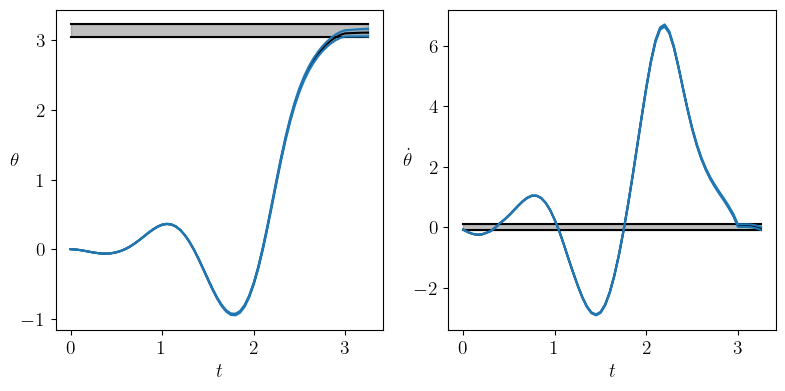

In [17]:
# Trajectory vs time

unrolledout = rollout_ol_sys_undisturbed(uu)
clrolledout = rollout_cl_embsys(uu)

if jnp.all(con_ineq(uu) >= -1e-3) :
    print(f'Constraints satisfied to {jnp.min(con_ineq(uu))}!')
else :
    print(f'Constraints not satisfied, worst is {jnp.min(con_ineq(uu))}!')
    print(con_ineq(uu))

fig1, axs = plt.subplots(1,2,dpi=100,figsize=[8,4])
fig1.subplots_adjust(top=0.95, bottom=0.15, left=0.075, right=0.975)

axs[0].set_xlabel('$t$'); axs[1].set_xlabel('$t$')
axs[0].set_ylabel('$\\theta$', rotation=0, labelpad=5)
axs[1].set_ylabel('$\\dot{\\theta}$', rotation=0, labelpad=5)
axs[0].plot(tt, unrolledout[:,0], color='k')
axs[1].plot(tt, unrolledout[:,1], color='k')
plot_interval_t(axs[0], tt, xf[0]*jnp.ones(N), color='k')
plot_interval_t(axs[1], tt, xf[1]*jnp.ones(N), color='k')
plot_interval_t(axs[0], tt, irx.interval(clrolledout[:,0], clrolledout[:,2]), color='tab:blue')
plot_interval_t(axs[1], tt, irx.interval(clrolledout[:,1], clrolledout[:,3]), color='tab:blue')
fig1.savefig('figures/pendulum.pdf')

plt.show()

If the figure did not load, please see [pendulum.pdf](./figures/pendulum.pdf).

In [16]:
# Animation of pendulum

to_plot = [clrolledout]
th2deg = lambda th : (th * 180) / jnp.pi - 90
anifig, anim = plt.subplots(1,len(to_plot),dpi=100,figsize=[4,4])
anifig.subplots_adjust()
wedge = anim.add_patch(Wedge((0,0),sys.l,th2deg(clrolledout[0,0]),th2deg(clrolledout[0,2]), lw=2, ec='k'))
anim.add_patch(Wedge((0,0), sys.l, th2deg(xfl[0]), th2deg(xfu[0]), color='k', alpha=0.25))
anim.set_xlim(-sys.l*1.2, sys.l*1.2)
anim.set_ylim(-sys.l*1.2, sys.l*1.2)
def animate(t) :
    wedge.set( theta1 = th2deg(clrolledout[t,0]), theta2 = th2deg(clrolledout[t,2]) )
    anifig.suptitle(f'$t = {t*dt:.2f}$')
    anifig.savefig(f'figures/frames/pendulum_{t:05d}.pdf')

ani = animation.FuncAnimation(anifig, animate, frames=N, repeat=True, interval=dt*1000)

FFwriter = animation.FFMpegWriter(fps=(1/dt))
ani.save('figures/pendulum.mp4', writer=FFwriter)

plt.close()

from IPython.display import Video
Video('figures/pendulum.mp4')

If the video did not render, please see [pendulum.mp4](./figures/pendulum.mp4).